In [2]:
# import all the libraries
import os, re, time, math
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import pysal as ps
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from spglm.family import Binomial
import multiprocessing as mp
from spglm.glm import GLM, GLMResults
from datetime import datetime
from sklearn.utils import resample
from shapely.geometry import Polygon

C:\Users\gsl\Anaconda3\envs\prat_env\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\Users\gsl\Anaconda3\envs\prat_env\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [3]:
epoch1_file = '../210912_Kathmandu_Epoch1_GWLR_PT_V1.csv'
df_epoch1 = pd.read_csv(epoch1_file)

# define a function for alphanumeric filename sorting
def sorted_nicely(l): 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

df_epoch1 = df_epoch1[sorted_nicely(df_epoch1.keys())]

print(df_epoch1.keys())

Index(['2000_AD_K5', '2000_BD_K3', '2000_BD_K13', '2000_VD_K5',
       '2000_dist_builtup', '2000_r1_dist', 'dist_hospitals', 'elevation',
       'growth_00_10', 'latitudes', 'longitudes', 'slope'],
      dtype='object')


In [4]:
# create geodatafram from pandas table
gdf_epoch1 = gpd.GeoDataFrame(df_epoch1, geometry=gpd.points_from_xy(df_epoch1.longitudes, df_epoch1.latitudes))
gdf_epoch1.crs = 'epsg:32645'

# spatial sampling using mesh
x_min, y_min, x_max, y_max = gdf_epoch1.total_bounds
print(x_min, y_min, x_max, y_max) #319587.97 3051480.8 350037.97 3080610.8

319587.97 3051480.8 350037.97 3080610.8


## Spatial stratified sampling using mesh

[322632.97 328722.97 334812.97 340902.97 346992.97]
[6090. 6090. 6090. 6090.]
[3054393.8 3060219.8 3066045.8 3071871.8 3077697.8]
[5826. 5826. 5826. 5826.]


<AxesSubplot:>

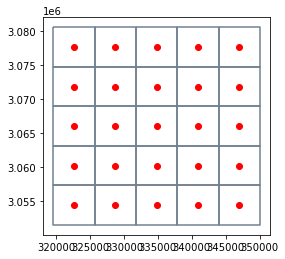

In [5]:
# using bounding box, determine the center of the grids for a n by m grid
X_SIZE = 5
Y_SIZE = 5

x_intervals = np.linspace(x_min, x_max, X_SIZE+1)
x_diff = np.diff(x_intervals)
x_centers = np.arange((x_min + x_diff[0]/2), (0.001 + x_max - x_diff[0]/2), x_diff[0])
print(x_centers)
print(np.diff(x_centers))

y_intervals = np.linspace(y_min, y_max, Y_SIZE+1)
y_diff = np.diff(y_intervals)
y_centers = np.arange((y_min + y_diff[0]/2), (0.001 + y_max - y_diff[0]/2), y_diff[0])
print(y_centers)
print(np.diff(y_centers))

# create points geodataframe
mesh_x_centers = np.meshgrid(x_centers, y_centers)[0].flatten()
mesh_y_centers = np.meshgrid(x_centers, y_centers)[1].flatten()
mesh_centroids = gpd.GeoDataFrame([], geometry=gpd.points_from_xy(mesh_x_centers, mesh_y_centers))

# define a function to create rectangular buffer
def rectangle_buffer(point, x_dist, y_dist):
    min_lon = point.x - x_dist
    max_lon = point.x + x_dist
    min_lat = point.y - y_dist
    max_lat = point.y + y_dist
    
    lon_list = [min_lon, max_lon, max_lon, min_lon, min_lon]
    lat_list = [max_lat, max_lat, min_lat, min_lat, max_lat]
    
    return Polygon(zip(lon_list, lat_list))

mesh_gdf = gpd.GeoDataFrame([], geometry=mesh_centroids.geometry.apply(
    lambda x: rectangle_buffer(x, x_diff[0]/2, y_diff[0]/2))
                               )

# Plot the results
fig, ax1 = plt.subplots()
mesh_centroids.plot(ax = ax1, color = 'red')
mesh_gdf.boundary.plot(ax=ax1, color = 'slategrey')

Number of 1s: 560. Number of 0s: 3202
Number of 1s: 2342. Number of 0s: 2982
Number of 1s: 3117. Number of 0s: 2959
Number of 1s: 891. Number of 0s: 3268
Number of 1s: 2. Number of 0s: 3301
Number of 1s: 96. Number of 0s: 3189
Number of 1s: 4250. Number of 0s: 2712
Number of 1s: 8877. Number of 0s: 1600
Number of 1s: 5173. Number of 0s: 2638
Number of 1s: 1940. Number of 0s: 3016
Number of 1s: 2058. Number of 0s: 2990
Number of 1s: 8394. Number of 0s: 2266
Number of 1s: 9708. Number of 0s: 328
Number of 1s: 8257. Number of 0s: 2138
Number of 1s: 2022. Number of 0s: 2982
Number of 1s: 332. Number of 0s: 3284
Number of 1s: 453. Number of 0s: 3300
Number of 1s: 9417. Number of 0s: 2222
Number of 1s: 2480. Number of 0s: 3026
Number of 1s: 147. Number of 0s: 3268
Number of 1s: 77. Number of 0s: 3171
Number of 1s: 84. Number of 0s: 3254
Number of 1s: 56. Number of 0s: 3235
Number of 1s: 53. Number of 0s: 3291
Number of 1s: 65. Number of 0s: 3156


0     Annotation(322633, 3.05439e+06, 'n_0=3202\n\nn...
1     Annotation(328723, 3.05439e+06, 'n_0=2982\n\nn...
2     Annotation(334813, 3.05439e+06, 'n_0=2959\n\nn...
3     Annotation(340903, 3.05439e+06, 'n_0=3268\n\nn...
4     Annotation(346993, 3.05439e+06, 'n_0=3301\n\nn...
5     Annotation(322633, 3.06022e+06, 'n_0=3189\n\nn...
6     Annotation(328723, 3.06022e+06, 'n_0=2712\n\nn...
7     Annotation(334813, 3.06022e+06, 'n_0=1600\n\nn...
8     Annotation(340903, 3.06022e+06, 'n_0=2638\n\nn...
9     Annotation(346993, 3.06022e+06, 'n_0=3016\n\nn...
10    Annotation(322633, 3.06605e+06, 'n_0=2990\n\nn...
11    Annotation(328723, 3.06605e+06, 'n_0=2266\n\nn...
12    Annotation(334813, 3.06605e+06, 'n_0=328\n\nn_...
13    Annotation(340903, 3.06605e+06, 'n_0=2138\n\nn...
14    Annotation(346993, 3.06605e+06, 'n_0=2982\n\nn...
15    Annotation(322633, 3.07187e+06, 'n_0=3284\n\nn...
16    Annotation(328723, 3.07187e+06, 'n_0=3300\n\nn...
17    Annotation(334813, 3.07187e+06, 'n_0=2222\

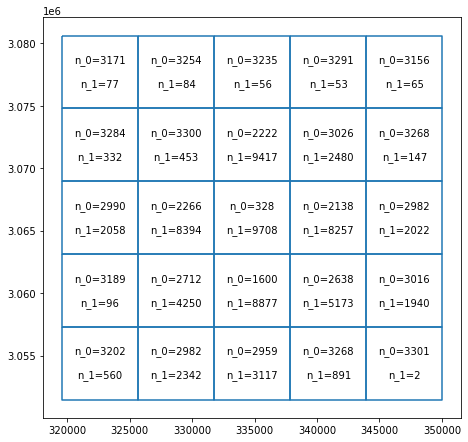

In [6]:
mesh_gdf['n_0'] = 0
mesh_gdf['n_1'] = 0

for index, row in mesh_gdf.iterrows():
    spatial_strata = gpd.clip(gdf_epoch1, row.geometry)
    n_1 = spatial_strata.loc[spatial_strata.growth_00_10==1].shape[0]
    
    mesh_gdf.loc[index, 'n_0'] = spatial_strata.shape[0] - n_1
    mesh_gdf.loc[index, 'n_1'] = n_1
    print('Number of 1s: %d. Number of 0s: %d' % (n_1, spatial_strata.shape[0] - n_1))

# plot the grid and export image
ax = mesh_gdf.geometry.boundary.plot(figsize=(7.5, 7.5))
mesh_gdf.apply(lambda x: ax.annotate(text='n_0=' + str(x['n_0']) + '\n\n' + 'n_1=' + str(x['n_1']), xy=x.geometry.centroid.coords[0], 
                                     ha='center', va='center'), axis=1)
plt.savefig('../Images/220207_SpatialStrata_PT_V1.png', dpi=300, format='PNG', bbox_inches='tight', pad_inches = 0)
plt.close(fig)

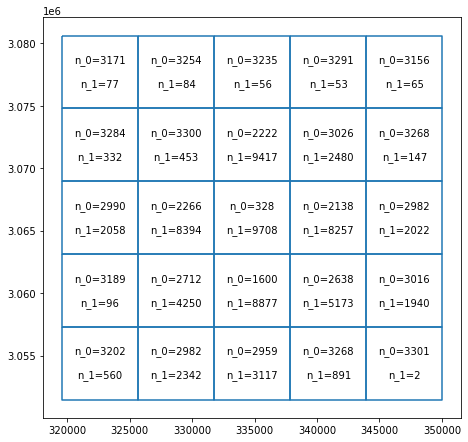

In [11]:

ax = mesh_gdf.geometry.boundary.plot(figsize=(7.5, 7.5))
mesh_gdf.apply(lambda x: ax.annotate(text='n_0=' + str(x['n_0']) + '\n\n' + 'n_1=' + str(x['n_1']), xy=x.geometry.centroid.coords[0], 
                                     ha='center', va='center'), axis=1)

plt.savefig('../Images/220206_SpatialStrata_PT_V1.png', dpi=300, format='PNG', bbox_inches='tight', pad_inches = 0)
plt.close(fig)

In [9]:
print(os.getcwd())
mesh_gdf[['n_0', 'n_1']].min(axis=1)#.sum()

G:\My Drive\KathmanduUrbanGrowth\urban_growth_GWLR\Scripts


0      560
1     2342
2     2959
3      891
4        2
5       96
6     2712
7     1600
8     2638
9     1940
10    2058
11    2266
12     328
13    2138
14    2022
15     332
16     453
17    2222
18    2480
19     147
20      77
21      84
22      56
23      53
24      65
dtype: int64

Number of records in each class:
Built: 70529, Unbuilt: 70529
Number of records in balanced classes:
Built: 7500, Unbuilt: 7500


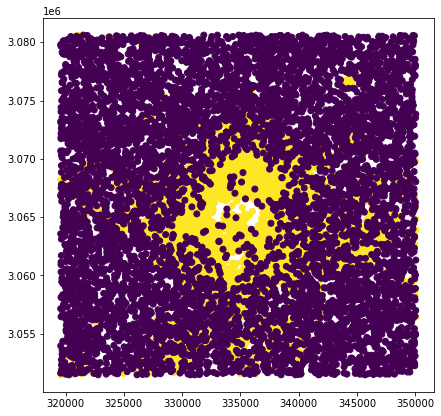

In [27]:
sample_size = 15000

# stratified sample classes
built = gdf_epoch1.loc[gdf_epoch1.growth_00_10==1]
unbuilt = gdf_epoch1.loc[gdf_epoch1.growth_00_10==0]

print('Number of records in each class:')
print('Built: %d, Unbuilt: %d' % (built.shape[0], unbuilt.shape[0]))

# Downsample the majority class
built = resample(built,
                 replace = False, # sample without replacement
                    n_samples = int(sample_size / 2), # match minority n
                    random_state = 2)

unbuilt = resample(unbuilt,
                  replace = False, # sample without replacement
                  n_samples = int(sample_size / 2), # match minority n
                  random_state = 2)

print('Number of records in balanced classes:')
print('Built: %d, Unbuilt: %d' % (built.shape[0], unbuilt.shape[0]))

# Combine the balanced features
gdf_epoch1 = pd.concat([built, unbuilt], axis=0)

fig, ax = plt.subplots(figsize = (7, 7))
gdf_epoch1.plot('growth_00_10', ax=ax)
plt.show()

In [4]:
# set up the data 
x_epoch1 = gdf_epoch1[['2000_AD_K5', '2000_BD_K3', '2000_BD_K13', '2000_VD_K5', '2000_dist_builtup', 
                       '2000_r1_dist', 'dist_hospitals', 'elevation', 'slope']].to_numpy()
y_epoch1 = gdf_epoch1['growth_00_10'].to_numpy().reshape((-1, 1))
g_coords = list(zip(gdf_epoch1.longitudes.values, gdf_epoch1.latitudes.values))

print(x_epoch1.shape)
print(y_epoch1.shape)

(141058, 9)
(141058, 1)


In [ ]:
# search for optimum bandwidth
t1 = time.time()

# create parallel processing
n_proc = mp.cpu_count()
pool = mp.Pool(n_proc)

# create search for bandwidth
gwr_selector = Sel_BW(g_coords, y_epoch1, x_epoch1, family=Binomial())
gwr_bw = gwr_selector.search(pool=pool, criterion='AICc', search_method='interval', bw_min=500, bw_max=2000, interval=100)

# close the pool
pool.close()
pool.join()

t2 = time.time()
print('Total time taken: %.2f minutes' % ((t2 - t1) / 60))

print(gwr_bw)
# earlier was 724

In [31]:
# create parallelisation
n_proc = 30 #two processors
pool = mp.Pool(n_proc)

# fit the model, print basic stats
gwr_model = GWR(g_coords, y_epoch1, x_epoch1, gwr_bw, family=Binomial())
gwr_results = gwr_model.fit(pool=pool)

# Close the pool when you finish
pool.close()
pool.join()

# print global stats
print(gwr_results.resid_ss) #1402.0653773759514
print(gwr_results.aic) #9561.290869417648
print(gwr_results.aicc) #9585.725977906948

1402.0653773759514
9561.290869417648
9585.725977906948


In [32]:
gwr_results.summary()

Model type                                                         Binomial
Number of observations:                                               15000
Number of covariates:                                                    10

Global Regression Results
---------------------------------------------------------------------------
Deviance:                                                         11381.834
Log-likelihood:                                                   -5690.917
AIC:                                                              11401.834
AICc:                                                             11401.848
BIC:                                                            -132759.090
Percent deviance explained:                                           0.453
Adj. percent deviance explained:                                      0.452

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [34]:
params = gwr_results.params

print(params.shape)

for x in range (0, 10):
    gdf_epoch1['x%d'%(x)] = params[:, x]
print(gdf_epoch1.keys())

time_stamp = datetime.now().strftime('%y%m%d')
gdf_epoch1.to_file('../output/%s_Kathmandu_Epoch1_GWR_Output_utm45n_PT_V1.shp' % (time_stamp))

(15000, 10)
Index(['2000_AD_K5', '2000_BD_K3', '2000_BD_K13', '2000_VD_K5',
       '2000_dist_builtup', '2000_r1_dist', 'dist_hospitals', 'elevation',
       'growth_00_10', 'latitudes', 'longitudes', 'slope', 'geometry', 'x0',
       'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'],
      dtype='object')


In [35]:
# stationarity test
variables = ['Intercept', '2000_AD_K5', '2000_BD_K3', '2000_BD_K13', '2000_VD_K5', 
             '2000_dist_builtup', '2000_r1_dist', 'dist_hospitals', 'elevation', 'slope']
stationarity_df = pd.DataFrame(index=variables, columns=['SE', 'STD', '2*SD', 'IQR', 'IQR-2*SD'])

# fit a global model
glm_model = GLM(y_epoch1, x_epoch1, family=Binomial())
glm_results = glm_model.fit()

#print(dir(glm_results))
#print(glm_results.bse)

for n, var in enumerate(variables):
    q3, q1 = np.percentile(params[:, n], [75, 25])
    iqr = np.round(q3 - q1, 3)
    
    se = np.round(glm_results.bse[n], 3)
    std = math.sqrt(gdf_epoch1.shape[0]) * se
    #print(2*std, iqr, se, var)
    
    stationarity_df.loc[var] = se, std, 2*std, iqr, iqr-2*std
    
print(stationarity_df)
stationarity_df.to_csv('../output/%s_Kathmandu_Epoch1_GWR_StationarityTest.csv' % (time_stamp))

                      SE       STD       2*SD    IQR   IQR-2*SD
Intercept          0.036  4.409082   8.818163  3.684  -5.134163
2000_AD_K5         0.025  3.061862   6.123724  0.488  -5.635724
2000_BD_K3         0.058   7.10352  14.207041  0.798 -13.409041
2000_BD_K13        0.062  7.593418  15.186836  1.473 -13.713836
2000_VD_K5         0.033  4.041658   8.083316  0.536  -7.547316
2000_dist_builtup  0.039  4.776505    9.55301  3.443   -6.11001
2000_r1_dist       0.028  3.429286   6.858571  0.517  -6.341571
dist_hospitals     0.038  4.654031   9.308061  3.012  -6.296061
elevation          0.045  5.511352  11.022704  2.994  -8.028704
slope              0.037  4.531556   9.063112  0.628  -8.435112
